# Demonstrating the effect of AT bias on our BFA data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in log10


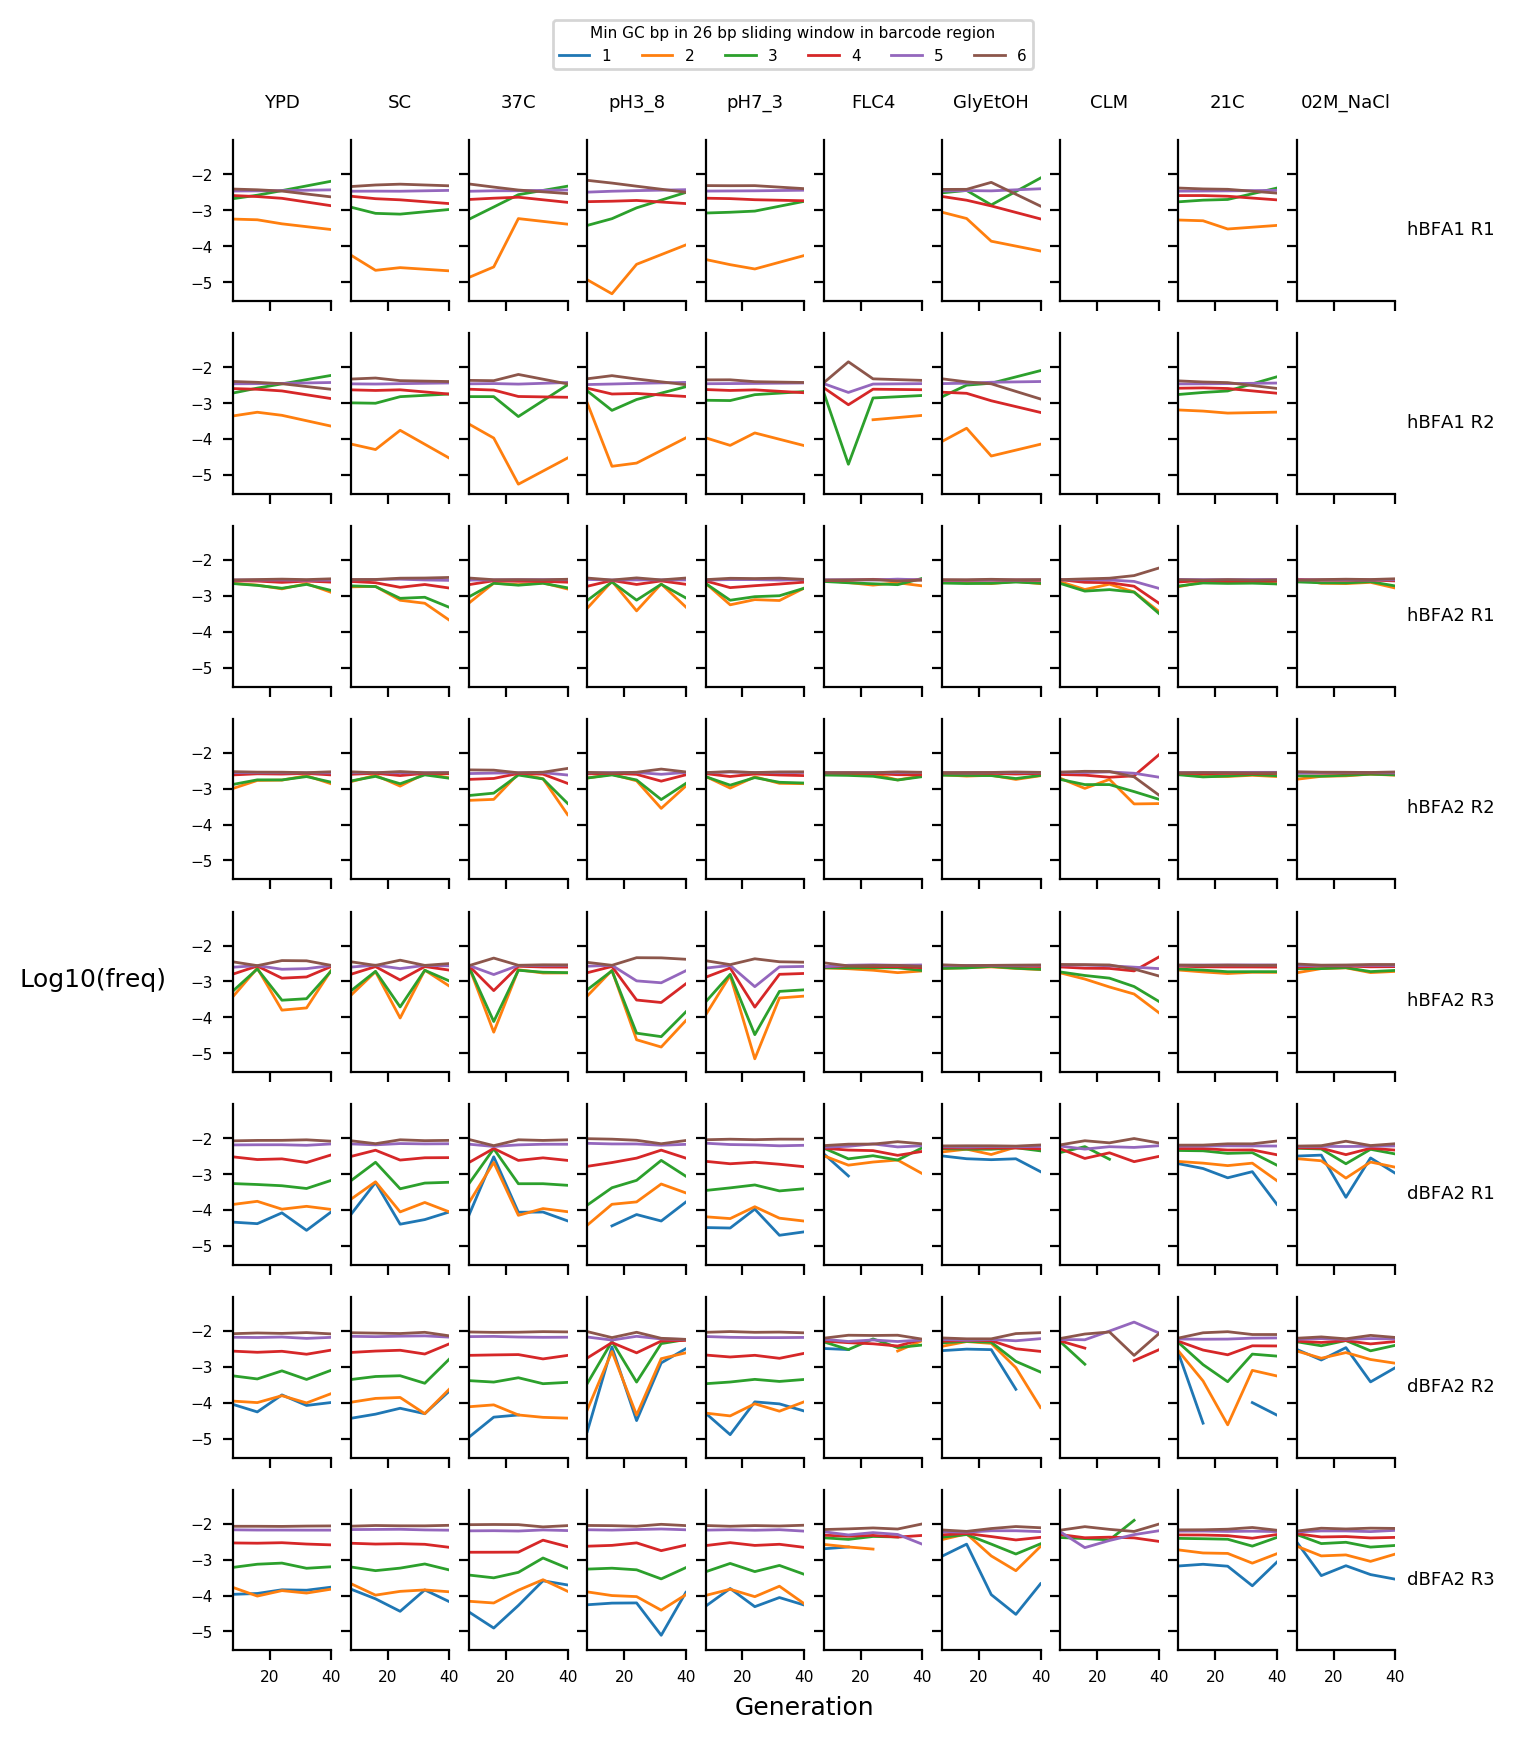

In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as pl
import seaborn as sns
import math

def reverse_complement(seq):
    """reverse complements a dna sequence (does not convert any non-atcg/ATCG characters)"""
    watson_crick = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'a': 't', 't': 'a', 'g': 'c', 'c': 'g'}
    return ''.join([watson_crick.setdefault(c, c) for c in seq[::-1]])

# including the sequence between the barcodes to get the max AT run of the whole region (which is flanked by CG seqs)
middle_seq = 'ATAACTTCGTATAATGTATGCTATACGAAGTTAT'

def gc(s):
    return len([i for i in s if i in ['G', 'C']])
    
def sliding_window_min(row, win_size):
    s = row['Diverse.BC'] + middle_seq + reverse_complement(row['Environment.BC'])
    return min([gc(s[i:i+win_size]) for i in range(len(s)-win_size+1)])

def plot_all_bias_terms(tds, outpng):
    f, subps = pl.subplots(8, len(all_envs), figsize=(7.5,10), sharex=True, sharey=True, dpi=200)
    rc = 0
    b = 0
    for td in tds:
        rep_dict = {e: sorted(set([i.split('-')[2] for i in td.keys() if e in i and 'Time' in i])) for e in all_envs}
        for rep in ['R1', 'R2', 'R3']:
            if len([i for i in all_envs if rep in rep_dict[i]]) > 0:
                for e in range(len(all_envs)):
                    env = all_envs[e]
                    sub = subps[rc][e]
                    tps = sorted([i for i in td.keys() if 'Time' in i and env + '-' + rep in i],
                                         key=lambda x: int(x[x.index('Time')+4:]))
                    times = [int(x[x.index('Time')+4:]) for x in tps]
                    gc_bias_effects = [[] for i in range(1, 7)]
                    for tp in tps:
                        for gc in range(6):
                            gc_bias_effects[gc].append(np.log10(np.mean(td.loc[td['min.lox.GC.w26']==gc+1][tp])/sum(td[tp])))
                    for gc in range(6):
                        sub.plot(times, gc_bias_effects[gc], label=str(gc+1), linewidth=1)
                    if rc == 0:
                        sub.set_title(env, y=1.1, fontsize=6.5)
                    if e == 9:
                        sub.set_ylabel(bfas[b] + ' ' + rep, fontsize=6.5, rotation='horizontal', ha='left', labelpad=20)
                        sub.yaxis.set_label_position("right")
                    if e == 0 and rc == 4:
                        sub.set_ylabel('Log10(freq)', fontsize=9, rotation='horizontal', labelpad=35)
                    if e == 4 and rc == 7:
                        sub.set_xlabel('Generation', fontsize=9, x=1)
                        
                    sub.set_xlim([8,40])
                    sub.tick_params(axis='both', which='major', labelsize=5.5)
                rc += 1
        b += 1
        
    sns.despine()
    leg = subps[0][6].legend(fontsize=5.5, ncol=6, bbox_to_anchor=(1,1.8), title='Min GC bp in 26 bp sliding window in barcode region')
    leg.get_title().set_fontsize('5.5')
    f.savefig(outpng)
    

bfas = ['hBFA1', 'hBFA2', 'dBFA2']
dats = dict()
putative_neuts = dict()
for b in bfas:
    dats[b] = pd.read_csv('../BFA_data/Combined_Counts/' + b + '_counts_with_env_info.csv')
putative_neuts['hBFA1'] = list(dats['hBFA1'].loc[dats['hBFA1']['Subpool.Environment'] == 'YPD_alpha']['Full.BC'])
putative_neuts['hBFA2'] = list(dats['hBFA2'].loc[dats['hBFA2']['Subpool.Environment'] == 'CLM_2N']['Full.BC'])
putative_neuts['dBFA2'] = list(dats['dBFA2'].loc[dats['dBFA2']['Subpool.Environment'] == 'Ancestor_YPD_2N'].loc[dats['dBFA2']['Which.Subpools'] == '-R1-1']['Full.BC'])
plot_rows = {'hBFA1': 2, 'hBFA2': 3, 'dBFA2': 3}
all_envs = ['YPD', 'SC', '37C', 'pH3_8', 'pH7_3', 'FLC4', 'GlyEtOH', 'CLM', '21C', '02M_NaCl']
for b in bfas:
    td = dats[b]
    # Getting the minimum GC content in a 26-bp sliding window
    td['min.lox.GC.w26'] = td.apply(lambda row: sliding_window_min(row, 26), axis=1)

plot_all_bias_terms([dats[b].loc[dats[b]['Full.BC'].isin(putative_neuts[b])] for b in bfas], '../Figures/supp_figs/all_at_bias.png')